# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import string
import re
import os

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

import seaborn as sns
import matplotlib.pyplot as plt

# Installed nltk

In [2]:
#pip install nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#import nltk
#nltk.download('punkt')

## Building functions

In [3]:
def get_Cross_Validate_Score (model,X_training_data,y_training_data):
    """This function estimates the accuracy of the machine learning model based 
        on any scoring optimization function you provide and
        It uses Stratified Shuffle Split to split the data.
        
        This function takes multiple inputs:
            1. model: defined varialbe 
            2. x_training_data: dataframe
            3. y_training_data: dataframe
            4. split_parm: parametes to split the data using Stratifiedshuffelsplit
            
        the output would be the score values used to optimise the model"""
    
    n_split = int(input(f'n_split:'))
    test_size = float(input(f'test_size:'))
    scoring = ['accuracy']
    s = StratifiedShuffleSplit(n_split,test_size,random_state=42)
    cross_validation_ = cross_validate(estimator=model, # the model to evaluate
                                     X=X_training_data,
                                     y=y_training_data,
                                     scoring=scoring, # evaluation metrics
                                     cv=s, # cross validation splitting
                                     verbose = 3)
    test_accuracy = round(sum((cross_validation_['test_accuracy'])/n_split)*100,2)
    
    return {print('*°'*20),
            print('test_accuracy:',test_accuracy,'%'),
            print('*°'*20)}

#########################################################################################################################

def Confusion_Matrix (Test, Predicted, Class, model):
    """This function will generate a confusion matrix heat map.
        The function will take 3 input arguments:
        1. Test: can be ytest or ytrain
        2. Predicted: can be ytest_predictes or ytrain_predicted
        3. Class: this is the list/vector of ytrain or ytest, it is just used 
            to automate the xtick and ytick labels
        4. model: str input of the model used
            eg: 'LR' for Logistic Regression."""
    
    
    corr_map = confusion_matrix(Test, Predicted)
    LABELS = ["Survived","Non_Survived"]
    sns.heatmap(corr_map,
                annot=True,
                cmap='BuPu',
                xticklabels=np.unique(Class), 
                yticklabels=np.unique(Class),
                fmt = 'd')
    plt.title(f'Confusion_Martix - {model}',fontsize=14)
    plt.ylabel("True class",fontsize=14)
    plt.xlabel("Predicted class",fontsize=14)

    return plt

########################################################################################################################
def Classification_Metric_models (Test, lists_Predicted, lists_models):
    """ 
        This function will produce a dataframe with 4 different classification 
        metrics for comparision:
        
        1. Accuracy_Score
        2. Precision_Score
        3. Recall_Score
        4. F1_Score
        
        This function requires 3 input arguments :
    
            1. Test 'y_test'
            2. Predicted will take a list of y_pred from multiple models
                eg: '[ypred_Random_Forest,ypred_Logistic_Regression, ....]'
            3. models will take a list (string) of all the model used.
                eg: '['Random_Forest','Logistic_Regression', ....]'
            **For Predicted and models the list item order should be preserved.
                
        """
    Scores = pd.DataFrame()
    
    for pred in lists_Predicted:
        Accuracy_Score=accuracy_score(Test, pred)*100
        Precision_Score=precision_score(Test, pred, average = 'weighted')*100
        Recall_Score=recall_score(Test, pred,average ='weighted')*100
        F1_Score=f1_score(Test, pred,average ='weighted')*100
        data = {'Accuracy_Score':round(Accuracy_Score,1), 'Precision_Score':round(Precision_Score,1), 'Recall_Score':round(Recall_Score,1), 'F1_Score':round(F1_Score,1) }
        Scores = Scores.append(data,ignore_index=True)
    Scores['Model'] = lists_models
    Scores.set_index('Model', inplace=True)
    
    return Scores

## Creating a Corpus

In [63]:
folders = ['Eminem','Jay-Z','Justin-Timberlake','50-Cent','Bob-Marley','Michael-Jackson','Akon']
corpus = []    #,
file_list_ = []
folder_len = []
base_url = r"C:/Users/Asus/OneDrive/Desktop/Spiced_Academy/naive-zatar-student-codes/week4/"
for folder in folders:
    full_path = base_url+folder
    #file_list_[folder] = os.listdir(full_path)
    folder = os.listdir(full_path)
    folder_len.append(len(folder))
    #print(folder)
    for filename in folder:
        final_path = full_path+'/'+ filename
        #print(final_path)
    
        with open(final_path, 'r',encoding="utf8") as f:
            bob_marley = f.read()
            corpus.append(bob_marley)
            f.close()

In [64]:
Corpus = []
for i in corpus:
    newstr = i.replace("\n", " ")
    Corpus.append(newstr)

In [65]:
#Corpus

In [66]:
print(folder_len) # number of songs from each artist
print(folders)

[440, 579, 164, 305, 173, 287, 243]
['Eminem', 'Jay-Z', 'Justin-Timberlake', '50-Cent', 'Bob-Marley', 'Michael-Jackson', 'Akon']


In [67]:
# Build labels

labels = []
for name , i in zip(folders, folder_len):
    labels.append([name]*i)

In [68]:
labels = [ item for elem in labels for item in elem]

## Processing the text by tokenizing and lemmatizing

In [69]:
from sklearn.feature_extraction import _stop_words
skl_stopwords=_stop_words.ENGLISH_STOP_WORDS

lemmatizer = WordNetLemmatizer()
tokenizer= TreebankWordTokenizer()

In [70]:
def tokenize_lemmatize(text, stopwords=skl_stopwords, tokenizer=tokenizer, lemmatizer=lemmatizer):
    panc = string.punctuation + '–'+ '‘'+ '’'+ '“'+'”'
    text = [i for i in text if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+",i)]
    text = ''.join([ch for ch in text if ch not in panc]) #remove punctuation
    text = re.sub(pattern= '[0-9]+', string= text, repl = ' ' )
    text = re.sub(pattern = '(aah|aaaa|aa)', string = text, repl ='')
    tokens = nltk.word_tokenize(text) 
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords] 

In [71]:
vectorizer = CountVectorizer(tokenizer=tokenize_lemmatize,encoding='utf-8', stop_words=None)

In [72]:
X = vectorizer.fit_transform(Corpus)

In [73]:
lyric_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())                     

In [74]:
lyric_df.head()

,ab,aback,abandon,abandoned,abay,abbey,abc,abdomen,abdominal,abdul,...,élèves,éléverons,équilibre,équipe,étoiles,être,ït,übern,œil,ɲi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# pd.set_option('max_columns', None)
# pd.set_option('max_rows', None)
# lyric_df

In [76]:
print(folders)

['Eminem', 'Jay-Z', 'Justin-Timberlake', '50-Cent', 'Bob-Marley', 'Michael-Jackson', 'Akon']


In [77]:
Labels = pd.DataFrame(labels, columns=['artist']) # inserting label col to the lyric_df dataframe.
Labels['artist'] = Labels['artist'].map({'Eminem':0,'Jay-Z':1,'Justin-Timberlake':2,'50-Cent':3, 'Bob-Marley':4, 'Michael-Jackson':5,'Akon':6})
#Labels.head()

## Train and Test

In [78]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

ros = RandomOverSampler(random_state=10, sampling_strategy="auto")

X_ros, y_ros = ros.fit_resample(lyric_df, Labels)

print(f'unique samples in each class (oversampled): \n{y_ros.value_counts()}')

unique samples in each class (oversampled): 
artist
0         579
1         579
2         579
3         579
4         579
5         579
6         579
dtype: int64


In [79]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_ros, y_ros, test_size=.25, random_state= 42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3039, 25028), (1014, 25028), (3039, 1), (1014, 1))

In [80]:
tf = TfidfTransformer() 
Xtrain_norm = tf.fit_transform(Xtrain)

In [81]:
Xtrain_norm

<3039x25028 sparse matrix of type '<class 'numpy.float64'>'
	with 374950 stored elements in Compressed Sparse Row format>

In [82]:
Xtrain_norm=pd.DataFrame(Xtrain_norm.todense(), columns=vectorizer.get_feature_names())
Xtrain_norm.shape

(3039, 25028)

In [83]:
#pip install imblearn

# Model1 : Naive Bayes

In [84]:
NB  = MultinomialNB(alpha=1).fit(Xtrain_norm, ytrain)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [85]:
print(f'Training score: {round(NB.score(Xtrain_norm, ytrain)*100,2)}%') 

Training score: 91.94%


In [86]:
Xtest_norm = tf.transform(Xtest)

In [87]:
Xtest_norm=pd.DataFrame(Xtest_norm.todense(), columns=vectorizer.get_feature_names())
#Xtest_norm.head()

In [88]:
print(f'Test score: {round(NB.score(Xtest_norm, ytest)*100,2)}%') 

Test score: 83.23%


In [89]:
ypred_NB = NB.predict(Xtest_norm)

In [90]:
get_Cross_Validate_Score(NB,Xtrain_norm, ytrain)

n_split:10
test_size:0.25


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass test_size=0.25 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.795) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.813) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.772) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.817) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.818) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.846) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.774) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.836) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.805) total time=   0.4s


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ............................. accuracy: (test=0.808) total time=   0.4s
*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°
test_accuracy: 80.84 %
*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°*°


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


{None}

# Model2: Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression

In [92]:
lm = LogisticRegression(max_iter= 1000, tol=0.001, random_state=42).fit(Xtrain_norm, ytrain)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [93]:
print(f'Training score {round(lm.score(Xtrain_norm, ytrain)*100,2)}%')

Training score 96.02%


In [94]:
ypred_LR = lm.predict(Xtest_norm)

In [95]:
print(f'Testing score {round(lm.score(Xtest_norm, ytest)*100,2)}%')

Testing score 87.28%


<module 'matplotlib.pyplot' from 'C:\\Users\\Asus\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

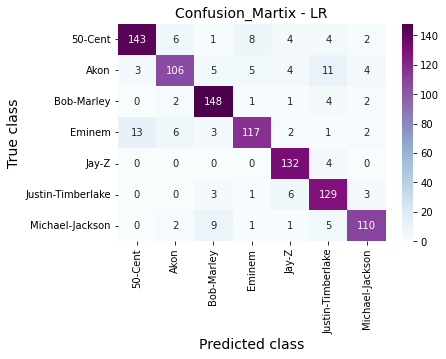

In [96]:
Confusion_Matrix (ytest, ypred_LR, labels, 'LR')

In [97]:
Classification_Metric_models(ytest, [ypred_LR],['Logistic_Regression'])

,Accuracy_Score,Precision_Score,Recall_Score,F1_Score
Model,,,,
Logistic_Regression,87.3,87.4,87.3,87.2


# Model3: Random Forest Classifier

In [98]:
from sklearn.ensemble import RandomForestClassifier
import multiprocessing

In [99]:
%%time
#n_estimators= 5000,min_samples_split= 350,min_samples_leaf= 7, max_depth=1000, random_state=101
RFC  = RandomForestClassifier(n_estimators= 2000,min_samples_split= 25,min_samples_leaf= 3, max_depth=500, random_state=101).fit(Xtrain_norm, ytrain)

<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Wall time: 2min 23s


In [100]:
ypred_rfc = RFC.predict(Xtest_norm)

In [101]:
print(f'Training score {round(RFC.score(Xtrain_norm, ytrain)*100,2)}%')
print(f'Testing score {round(RFC.score(Xtest_norm, ytest)*100,2)}%')
print(f'error: {round(RFC.score(Xtrain_norm, ytrain)*100,2) - round(RFC.score(Xtest_norm, ytest)*100,2)}%')

Training score 96.51%
Testing score 89.94%
error: 6.570000000000007%


In [102]:
Classification_Metric_models(ytest, [ypred_rfc], ['Random_Forest'])

,Accuracy_Score,Precision_Score,Recall_Score,F1_Score
Model,,,,
Random_Forest,89.9,90.4,89.9,89.9


<module 'matplotlib.pyplot' from 'C:\\Users\\Asus\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

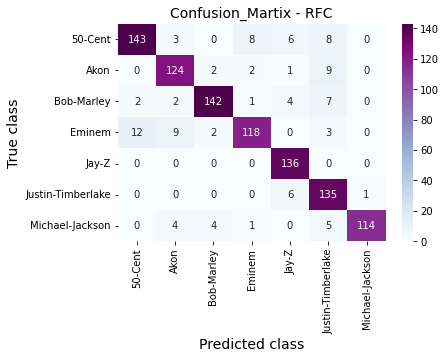

In [103]:
Confusion_Matrix (ytest, ypred_rfc, labels, 'RFC')

In [104]:
Classification_Metric_models(ytest, [ypred_NB, ypred_LR, ypred_rfc], ['Naive_Bayes','Logistic_Regression','Random_Forest'])

,Accuracy_Score,Precision_Score,Recall_Score,F1_Score
Model,,,,
Naive_Bayes,83.2,84.7,83.2,83.3
Logistic_Regression,87.3,87.4,87.3,87.2
Random_Forest,89.9,90.4,89.9,89.9


#### By looking at both training and testing accuracy, Naive Bayes and Logistic regression have found to overfit the data when compared to Random forest classifiser.